# Neural Collaborative Filtering: Small Dataset Results

### Import Data

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.layers
import tensorflow as tf
from keras import regularizers
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

train_data = pd.read_csv("cleandata/train_small.csv")
test_data = pd.read_csv("cleandata/test_small2.csv")
train_data = train_data.rename(columns={"userId": "user_id", "movieId": "business_id"})
test_data = test_data.rename(columns={"userId": "user_id", "movieId": "business_id"})

In [18]:
train_data['is_train'] = True
test_data['is_train'] = False
all_data = pd.concat([train_data,test_data])
all_data.user_id = all_data.user_id.astype('category').cat.codes.values
all_data.business_id = all_data.business_id.astype('category').cat.codes.values
is_train = all_data['is_train'] == True
train_data = all_data[is_train]
test_data = all_data[~is_train]

In [19]:
all_data

,user_id,business_id,date_review,rating_review,is_train
0,16727,73770,2012-09-14 08:38:47,5.0,True
1,3511,73770,2017-08-11 18:52:05,5.0,True
2,7049,73770,2012-02-04 21:13:37,2.0,True
3,19208,73770,2011-01-22 01:58:35,1.0,True
4,3801,73770,2015-05-08 20:55:25,2.0,True
...,...,...,...,...,...
59995,1903,37747,2016-07-05 21:54:34,4.0,False
59996,4129,12394,2016-12-11 01:29:08,4.0,False
59997,16956,35860,2012-08-07 15:35:03,4.0,False
59998,14735,13544,2014-04-11 22:46:39,5.0,False


### Model

In [20]:
n_latent_factors_user = 8
n_latent_factors_business = 10
n_latent_factors_mf = 3
n_users, n_business = len(all_data.user_id.unique()), len(all_data.business_id.unique())

In [21]:
business_input = keras.layers.Input(shape=[1],name='Item')
business_embedding_mlp = keras.layers.Embedding(n_business + 1, n_latent_factors_business, name='Business-Embedding-MLP')(business_input)
business_vec_mlp = keras.layers.Flatten(name='FlattenBusiness-MLP')(business_embedding_mlp)
business_vec_mlp = keras.layers.Dropout(0.2)(business_vec_mlp)

business_embedding_mf = keras.layers.Embedding(n_business + 1, n_latent_factors_mf, name='business-Embedding-MF')(business_input)
business_vec_mf = keras.layers.Flatten(name='Flattenbusiness-MF')(business_embedding_mf)
business_vec_mf = keras.layers.Dropout(0.2)(business_vec_mf)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec_mlp = keras.layers.Flatten(name='FlattenUsers-MLP')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding-MLP')(user_input))
user_vec_mlp = keras.layers.Dropout(0.2)(user_vec_mlp)

user_vec_mf = keras.layers.Flatten(name='FlattenUsers-MF')(keras.layers.Embedding(n_users + 1, n_latent_factors_mf,name='User-Embedding-MF')(user_input))
user_vec_mf = keras.layers.Dropout(0.2)(user_vec_mf)

In [22]:
concat = keras.layers.concatenate([business_vec_mlp, user_vec_mlp], name='Concat')

concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(128, name='FullyConnected')(concat_dropout)
dense_act = keras.layers.advanced_activations.LeakyReLU(alpha=0.3)(dense)
dense_batch = keras.layers.BatchNormalization(name='Batch')(dense_act)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout-1')(dense_batch)
dense_2 = keras.layers.Dense(64,name='FullyConnected-1')(dropout_1)
dense_batch_2 = keras.layers.BatchNormalization(name='Batch-2')(dense_2)

dropout_2 = keras.layers.Dropout(0.2,name='Dropout-2')(dense_batch_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dropout_2)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3')(dense_3)
dense_4_act = keras.layers.advanced_activations.LeakyReLU(alpha=0.3)(dense_4)

pred_mf = keras.layers.concatenate([business_vec_mf, user_vec_mf], name='Dot')
pred_mlp = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4_act)

combine_mlp_mf = keras.layers.concatenate([pred_mf, pred_mlp],name='Concat-MF-MLP')
result_combine = keras.layers.Dense(100, name='Combine-MF-MLP')(combine_mlp_mf)
deep_combine = keras.layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), name='FullyConnected-4')(result_combine)
dropout_3 = keras.layers.Dropout(0.3,name='Dropout-3')(deep_combine)

result = keras.layers.Dense(1, name='Prediction')(deep_combine)

In [23]:
model = keras.Model([user_input, business_input], result)
model.compile(optimizer='adam',loss= 'mse', metrics =["accuracy", "mse"])

In [24]:
history = model.fit([train_data.user_id.values, train_data.business_id.values], train_data.rating_review, epochs=20, validation_split=0.2)

A:\Anaconda\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 207104 samples, validate on 51777 samples
Epoch 1/20
207104/207104 [==============================] - 192s 928us/step - loss: 1.5995 - accuracy: 0.2938 - mse: 1.5800 - val_loss: 2.1350 - val_accuracy: 0.1890 - val_mse: 2.1243
Epoch 2/20
207104/207104 [==============================] - 188s 908us/step - loss: 1.2680 - accuracy: 0.3516 - mse: 1.2611 - val_loss: 2.1427 - val_accuracy: 0.1712 - val_mse: 2.1383
Epoch 3/20
207104/207104 [==============================] - 187s 903us/step - loss: 1.1750 - accuracy: 0.3774 - mse: 1.1715 - val_loss: 2.1579 - val_accuracy: 0.1636 - val_mse: 2.1552
Epoch 4/20
207104/207104 [==============================] - 172s 830us/step - loss: 1.1279 - accuracy: 0.3909 - mse: 1.1255 - val_loss: 2.1496 - val_accuracy: 0.1718 - val_mse: 2.1475
Epoch 5/20
207104/207104 [==============================] - 169s 814us/step - loss: 1.0985 - accuracy: 0.4014 - mse: 1.0966 - val_loss: 2.1460 - val_accuracy: 0.1719 - val_mse: 2.1444
Epoch 6/20
207104/207104 [===

### Evaluating Model

#### All Review Results

In [25]:
from sklearn.metrics import mean_squared_error
prediction = model.predict([test_data.user_id.values, test_data.business_id.values])

In [26]:
y_hat_rounded = np.round(prediction, 0)
print(np.sqrt(mean_squared_error(test_data.rating_review, y_hat_rounded)))
print(np.sqrt(mean_squared_error(test_data.rating_review, prediction)))

1.4701813947038418
1.4386594227617993


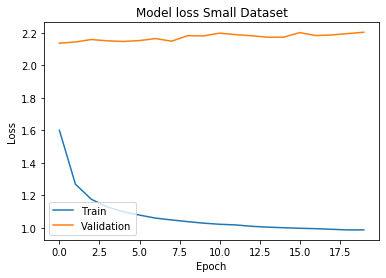

In [37]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss Small Dataset')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower left')
plt.show()

In [28]:
prediction

array([[3.7071753],
       [3.9028566],
       [4.347692 ],
       ...,
       [3.4718204],
       [3.3162842],
       [3.4221017]], dtype=float32)

In [29]:
# pd.DataFrame(prediction).to_csv('gs://zw2624-bucket/output/leaky_relu_prediction.csv')
pd.DataFrame(prediction).to_csv('small_dataset_leaky_relu_prediction_copy.csv')

In [30]:
test_data['predicted'] = pd.DataFrame(prediction)

A:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### User Coverage

In [31]:
test_data['predicted'] = pd.DataFrame(prediction)
correct = 0
for user in test_data.user_id:
    real = np.argsort(test_data.loc[test_data['user_id'] == user]['rating_review'])
    pred = np.argsort(test_data.loc[test_data['user_id'] == user]['predicted'])
    correct += (list(real) == list(pred))

A:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
correct/3 / len(test_data.user_id.unique())

0.2037

#### Last Review Results

In [33]:
idx = test_data.groupby(['user_id'])['date_review'].transform(max) == test_data['date_review']
test_data_latest = test_data[idx]
print(np.sqrt(mean_squared_error(test_data_latest.rating_review, test_data_latest.predicted)))

1.4710930978825
